# K-Day User Constraint for Weather Data Generation (Rainy Spring)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import scipy
from scipy.stats import chisquare
from collections import Counter

## Load Data

In [3]:
data_raw = pd.read_csv('data/data-2010-2024.csv', delimiter=",", skiprows=3)
# changed to dec of 2024 
data_test = pd.read_csv('data/om-apr2025.csv', delimiter=",", skiprows=3 )

In [4]:
weather_columns = {
    'temperature_2m (°C)': 'temp',
    'weather_code (wmo code)': 'weather_code',
    'precipitation (mm)': 'precip',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'sunshine_duration (s)': 'sunshine',    
}

def rename_columns(df):
    df.rename(columns=weather_columns, inplace=True)
    return df

def add_time_columns(df):
    constant_year = 2000
    df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Handle parsing errors
    df = df.dropna(subset=['time'])  # Drop rows with invalid dates
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['year'] = df['time'].dt.year
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    df['hour'] = df['time'].dt.hour
    df['month_day_time'] = pd.to_datetime(
        df['month'].astype(str) + '-' +
        df['day'].astype(str) + '-' +
        str(constant_year) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':' +
        df['minute'].astype(str).str.zfill(2) + ':' +
        df['second'].astype(str).str.zfill(2),
        format='%m-%d-%Y %H:%M:%S'
    )
    return df

In [5]:
data_test['time'] = pd.to_datetime(data_test['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
data_raw['time'] = pd.to_datetime(data_raw['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
all_data = rename_columns(data_raw)
all_data = add_time_columns(all_data)
test_data = rename_columns(data_test)
test_data = add_time_columns(test_data)

In [6]:
test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')

## Categorize Weather Variables

In [7]:
## Average the data
daily_mean_df = all_data.groupby(['year', 'month', 'day']).mean().reset_index()
daily_mean_test_df = test_data.select_dtypes(include=[np.number]).groupby(['year', 'month', 'day']).mean().reset_index()

In [8]:
# Calculate Monthly Percentiles

def calculate_percentiles_and_categorize(df, month):
    """
    Calculates percentiles for a specific month and categorizes weather variables into low, medium, and high.
    Includes zero precipitation values in the "Low" category.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
        month (int): The month for which to calculate percentiles (1 = January, ..., 12 = December).

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for categorized weather variables.
    """
    # Filter data for the specified month
    month_data = df[df['month'] == month].copy()

    # Calculate percentiles for each weather variable
    thresholds = {}
    for variable in ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']:
        variable_data = month_data[variable].dropna()

        if variable == 'precip':
            # Include zero values in the "Low" category
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}
        else:
            # Standard percentile calculation
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}

    # Categorize each variable based on the calculated thresholds
    for variable in thresholds.keys():
        low, high = thresholds[variable]['low'], thresholds[variable]['high']
        month_data[f'{variable}_category'] = month_data[variable].apply(
            lambda x: 'Low' if x <= low else 'Medium' if x < high else 'High'
        )

    return month_data

In [9]:
df_states1 = calculate_percentiles_and_categorize(daily_mean_df, 4)
# change month! 
df_states1_test = calculate_percentiles_and_categorize(daily_mean_test_df, 4)

In [10]:
# combine categories to make a weather state with temperature and precipitation
df_states1['state1'] = df_states1[['temp_category', 'precip_category']].agg('-'.join, axis=1)
df_states1_test['state1_test'] = df_states1_test[['temp_category', 'precip_category']].agg('-'.join, axis=1)

## Transition Matrix 

In [11]:
df = df_states1[['state1']].copy()
df_test = df_states1_test[['state1_test']].copy()
# Define the next state
df['next_state'] = df['state1'].shift(-1)
# Drop the last row since it has no next state
df = df.dropna(subset=['next_state'])
# Create a transition matrix with raw counts
transition_counts = pd.crosstab(df['state1'], df['next_state'])
# Normalize the transition counts to calculate probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Fill NaN values with 0 (in case some rows have no transitions)
transition_matrix = transition_matrix.fillna(0)
print(transition_matrix)

next_state     High-High  High-Low  High-Medium  Low-High   Low-Low  \
state1                                                                
High-High       0.311111  0.200000     0.133333  0.044444  0.000000   
High-Low        0.120000  0.573333     0.106667  0.013333  0.040000   
High-Medium     0.375000  0.156250     0.250000  0.031250  0.000000   
Low-High        0.035714  0.000000     0.000000  0.482143  0.107143   
Low-Low         0.000000  0.037037     0.018519  0.111111  0.425926   
Low-Medium      0.025641  0.000000     0.000000  0.230769  0.256410   
Medium-High     0.037736  0.000000     0.075472  0.132075  0.094340   
Medium-Low      0.044776  0.208955     0.059701  0.029851  0.059701   
Medium-Medium   0.107143  0.071429     0.035714  0.000000  0.107143   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High        0.000000     0.222222    0.044444       0.044444  
High-Low      

## Add values for each category 

In [12]:
def values_list(df, weather_var, category, weather_cat): 
    '''Creates a list of values for each weather variable for each category'''
    cat_rows = df.loc[df[weather_cat] == category]
    val_list = cat_rows[weather_var].to_list() 
    v_list = [ '%.1f' % elem for elem in val_list ]
    return v_list

In [13]:
# get low, med, high temperatures of january for further implementation
temp_low1 = values_list(df_states1, 'temp', 'Low', 'temp_category')
temp_med1 = values_list(df_states1, 'temp', 'Medium', 'temp_category')
temp_high1 = values_list(df_states1, 'temp', 'High', 'temp_category')

# get low, med, high precipitation of january for further implementation
prec_low1 = values_list(df_states1, 'precip', 'Low', 'precip_category')
prec_med1 = values_list(df_states1, 'precip', 'Medium', 'precip_category')
prec_high1 = values_list(df_states1, 'precip', 'High', 'precip_category')

all_temp = temp_low1 + temp_med1 + temp_high1

In [14]:
from scipy.stats import norm, gamma

temp_low1 = [float(x) for x in temp_low1]
temp_med1 = [float(x) for x in temp_med1]
temp_high1 = [float(x) for x in temp_high1]

prec_low1 = [float(x) for x in prec_low1]
prec_med1 = [float(x) for x in prec_med1]
prec_high1 = [float(x) for x in prec_high1]
# Example: fit temperature distributions
temp_low_params = norm.fit(temp_low1)  # returns mean and std
temp_med_params = norm.fit(temp_med1)
temp_high_params = norm.fit(temp_high1)

## Markov Chain Implementation

In [15]:
def simulate_markov_chain(transition_matrix, states, initial_state, steps):
    '''
    Simulates a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state for the simulation
        steps: Number of steps to simulate
        
    Returns:
        List of states in the simulated sequence
    '''

    # initialise current state
    current_state = initial_state
    
    # add current state to the list of sequences 
    state_sequence = [current_state]
    
    # generate n steps of states
    for _ in range(steps):
        # get probability for the current state
        probabilities = transition_matrix.loc[current_state].values
        # choose the next state based on the probabilities 
        next_state = np.random.choice(states, p=probabilities)
        state_sequence.append(next_state)
        current_state = next_state
    
    return state_sequence

In [16]:

def monte_carlo_markov_chain(transition_matrix, states, initial_state=None, steps=14, n_simulations=1000):
    '''
    Performs Monte Carlo simulation of a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state (if None, will be randomly chosen based on stationary distribution)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences (optional, can be removed if memory is a concern)
    '''


    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}

    # If no initial state is provided, use stationary distribution to choose one
    if initial_state is None:
        # Approximate stationary distribution by raising transition matrix to high power
        # This requires transition_matrix to be a numpy array, so convert if needed
        if isinstance(transition_matrix, pd.DataFrame):
            tm_numpy = transition_matrix.values
        else:
            tm_numpy = transition_matrix
            
        # Initialize a uniform distribution
        p = np.ones(len(states)) / len(states)
        
        # Multiply by transition matrix multiple times to approximate stationary distribution
        for _ in range(100):  # Usually 100 iterations is enough for convergence
            p = p @ tm_numpy
            
        # Choose initial state based on stationary distribution
        initial_state = np.random.choice(states, p=p)
    
    # Run n_simulations
    for _ in range(n_simulations):
        # For each simulation, potentially use a different initial state from stationary distribution
        if initial_state is None:
            sim_initial_state = np.random.choice(states, p=p)
        else:
            sim_initial_state = initial_state
            
        # Run one simulation
        sequence = simulate_markov_chain(transition_matrix, states, sim_initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences 
    }



In [17]:

def analyze_monte_carlo_results(mc_results, real_data, states, test_sequence=None):
    '''
    Analyzes and visualizes the results of Monte Carlo simulation
    
    Args:
        mc_results: Results from monte_carlo_markov_chain function
        real_data: Dictionary or Counter with actual observed frequencies
        states: List of possible states
        test_sequence: Optional test sequence to compare with simulated sequences
        
    Returns:
        Dictionary with analysis metrics
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import chisquare
    
    # Extract results
    mean_counts = mc_results['mean_counts']
    std_counts = mc_results['std_counts']
    ci_lower = mc_results['ci_lower']
    ci_upper = mc_results['ci_upper']
    
    # Prepare data for visualization
    simulated_means = [mean_counts[state] for state in states]
    error_bars = [std_counts[state] for state in states]
    real_counts = [real_data.get(state, 0) for state in states]
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, simulated_means, width, label='Simulated (Monte Carlo)', yerr=error_bars, alpha=0.7)
    plt.bar(x + width/2, real_counts, width, label='Real Data', alpha=0.7)
    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Simulation vs. Real Weather States')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig('monte_carlo_analysis.png')
    
    # Calculate Chi-square statistic
    chi2_stat, p_value = chisquare(f_obs=real_counts, f_exp=simulated_means)
    
    # Calculate mean absolute error
    mae = np.mean([abs(real_counts[i] - simulated_means[i]) for i in range(len(states))])
    mse = np.mean([(real_counts[i] - simulated_means[i])**2 for i in range(len(states))])
    mape = np.mean([abs(real_counts[i] - simulated_means[i]) / real_counts[i] for i in range(len(states)) if real_counts[i] != 0])
    
    # Check if real values fall within confidence intervals
    within_ci = [ci_lower[state] <= real_data.get(state, 0) <= ci_upper[state] for state in states]
    percent_within_ci = sum(within_ci) / len(states) * 100

    # Prepare results
    results = {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'statistically_similar': p_value > 0.05,
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'mean_absolute_percentage_error': mape,
        'percent_within_ci': percent_within_ci,
        'states_outside_ci': [states[i] for i in range(len(states)) if not within_ci[i]]
    }
    
    # Print summary
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Distributions are statistically similar: {p_value > 0.05}")
    print(f"Mean absolute error: {mae:.2f}")
    print(f"Mean squared error: {mse:.2f}")
    print(f"Mean absolute percentage error: {mape:.2f}")
    print(f"Percentage of states within 95% CI: {percent_within_ci:.1f}%")
    print(f"States outside confidence intervals: {results['states_outside_ci']}")
    
    return results

In [18]:
# Count the frequency of each state
from collections import Counter

# List of all states
all_states = transition_matrix.index.tolist()

# Initial state (choose one from the list of states)
initial_state = np.random.choice(all_states) 

# Simulate the Markov Chain
steps = 30
state_sequence = simulate_markov_chain(transition_matrix, all_states, initial_state, steps)
state_counts = Counter(state_sequence)

state_sequence_test = []
for i in df_test['state1_test']:
    state_sequence_test.append(i)

state_counts_test = Counter(state_sequence_test)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are:
1.0000000000000002

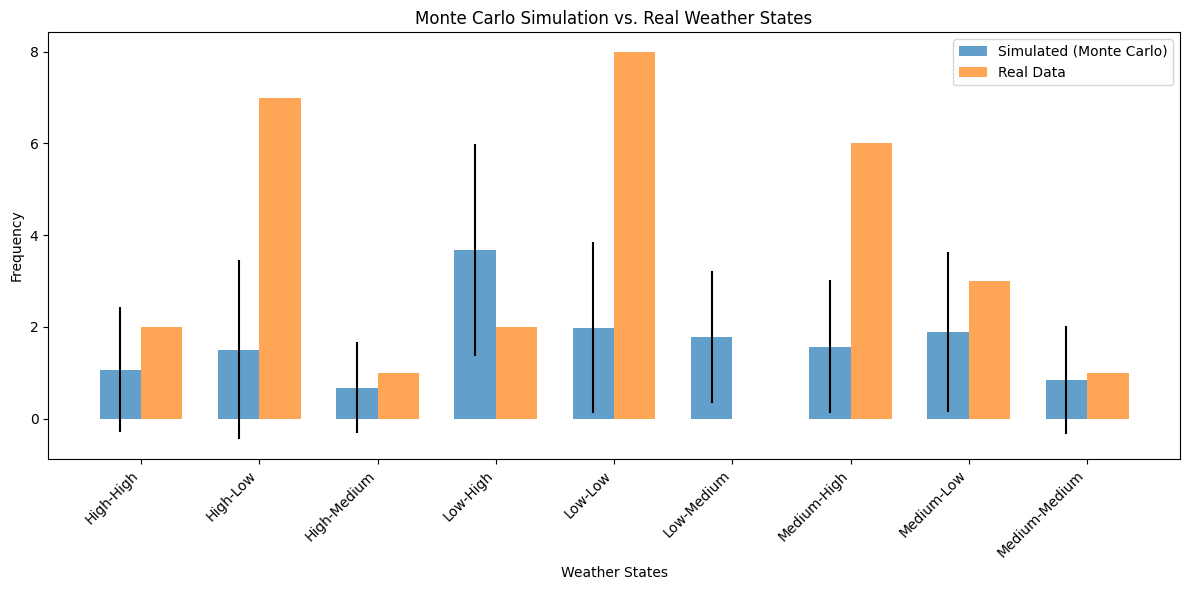

In [19]:

# Run Monte Carlo simulation
mc_results = monte_carlo_markov_chain(
    transition_matrix=transition_matrix,
    states=all_states, 
    steps=14,  
    n_simulations=1000, 
)

# Analyze results
analysis = analyze_monte_carlo_results(
    mc_results=mc_results,
    real_data=state_counts_test, 
    states=all_states,
    test_sequence= state_sequence_test
)

## Constrained Markov Chain - k-Day Constraint 

In [21]:

def get_run_lengths(sequence, target_state):
    """
    Get all run lengths for target_state in sequence
    
    Args:
        sequence: List of states
        target_state: State to analyze runs for
        
    Returns:
        List of run lengths
    """
    runs = []
    current_run = 0
    
    for state in sequence:
        if state == target_state:
            current_run += 1
        else:
            if current_run > 0:
                runs.append(current_run)
                current_run = 0
    
    # Don't forget the last run if sequence ends with target state
    if current_run > 0:
        runs.append(current_run)
    
    return runs


def validate_k_consecutive_constraint(sequence, target_state, k):
    """
    Check if sequence has exactly one run of exactly k consecutive target states
    
    Args:
        sequence: List of states
        target_state: The target state to check for
        k: Required number of consecutive occurrences
        
    Returns:
        Boolean indicating if constraint is satisfied
    """
    runs = get_run_lengths(sequence, target_state)
    
    # Check if there's exactly one run of length k
    k_runs = runs.count(k)
    longer_runs = sum(1 for run in runs if run > k)
    
    return k_runs == 1 and longer_runs == 0


def generate_k_consecutive_days_sequence_v2(transition_matrix, states, target_state, k, 
                                          initial_state=None, steps=30, max_attempts=1000):
    """
    Generate a sequence with exactly k consecutive occurrences of target_state using state repeater approach
    
    Args:
        transition_matrix: Your transition probability matrix (Pandas DataFrame)
        states: List of possible states
        target_state: State that must appear in exactly k consecutive days
        k: Number of consecutive days required
        initial_state: Starting state (if None, will be randomly selected)
        steps: Number of days to generate
        max_attempts: Maximum number of attempts to generate valid sequence
        
    Returns:
        A sequence that contains exactly k consecutive occurrences of target_state
    """
    
    for attempt in range(max_attempts):
        # Initialize sequence
        if initial_state is None:
            current_state = np.random.choice(states)
        else:
            current_state = initial_state
            
        sequence = [current_state]
        consecutive_count = 0
        k_streak_completed = False
        
        # If we start with target state, count it
        if current_state == target_state:
            consecutive_count = 1
        
        # Generate the rest of the sequence
        for step in range(steps):
            # If we're currently in the target state
            if current_state == target_state:
                # If we've reached k consecutive days, force transition away
                if consecutive_count >= k:
                    # Force transition to a different state
                    other_states = [s for s in states if s != target_state]
                    if other_states:  # Make sure there are other states
                        current_state = np.random.choice(other_states)
                        consecutive_count = 0
                        k_streak_completed = True
                    else:
                        # If target_state is the only state, we can't avoid it
                        current_state = target_state
                        consecutive_count += 1
                else:
                    # Continue the streak - stay in target state
                    current_state = target_state
                    consecutive_count += 1
            else:
                # Not in target state
                consecutive_count = 0
                
                # If we haven't completed the k-streak yet, occasionally transition to target state
                if not k_streak_completed and np.random.random() < 0.3:  # 30% chance to start streak
                    current_state = target_state
                    consecutive_count = 1
                else:
                    # Normal transition based on transition matrix
                    probabilities = transition_matrix.loc[current_state].values
                    current_state = np.random.choice(states, p=probabilities)
            
            sequence.append(current_state)
        
        # Validate the sequence has exactly one run of k consecutive target states
        if validate_k_consecutive_constraint(sequence, target_state, k):
            return sequence
    
    # If we couldn't generate a valid sequence naturally, use insertion method
    print(f"Warning: Could not generate valid sequence after {max_attempts} attempts.")
    print("Using insertion method to guarantee constraint.")
    return insert_k_consecutive_days(transition_matrix, states, target_state, k, initial_state, steps)


def insert_k_consecutive_days(transition_matrix, states, target_state, k, initial_state, steps):
    """
    Fallback method: Generate base sequence and insert k consecutive days
    
    Args:
        transition_matrix: Transition matrix
        states: List of possible states
        target_state: State to insert consecutively
        k: Number of consecutive days
        initial_state: Starting state
        steps: Total sequence length
        
    Returns:
        Sequence with exactly k consecutive target states
    """
    # Generate base sequence
    if initial_state is None:
        initial_state = np.random.choice(states)
    
    base_sequence = simulate_markov_chain(transition_matrix, states, initial_state, steps)
    
    # Find a suitable position to insert k consecutive target states
    # We need at least k positions, so max start is len(sequence) - k
    max_start = len(base_sequence) - k
    if max_start < 0:
        raise ValueError(f"Cannot fit {k} consecutive days in sequence of length {len(base_sequence)}")
    
    # Choose random position
    start_pos = np.random.randint(0, max_start + 1)
    
    # Insert k consecutive target states
    for i in range(k):
        base_sequence[start_pos + i] = target_state
    
    # Clean up any other occurrences of target state that might create longer runs
    # Check before the inserted block
    for i in range(start_pos - 1, -1, -1):
        if base_sequence[i] == target_state:
            # Replace with a different state
            other_states = [s for s in states if s != target_state]
            if other_states:
                base_sequence[i] = np.random.choice(other_states)
        else:
            break
    
    # Check after the inserted block
    for i in range(start_pos + k, len(base_sequence)):
        if base_sequence[i] == target_state:
            # Replace with a different state
            other_states = [s for s in states if s != target_state]
            if other_states:
                base_sequence[i] = np.random.choice(other_states)
        else:
            break
    
    return base_sequence


def monte_carlo_k_consecutive_v2(transition_matrix, states, target_state, k,
                               initial_state=None, steps=31, n_simulations=1000):
    """
    Monte Carlo simulation using the improved k-consecutive constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        target_state: State that must appear exactly k consecutive times
        k: Number of consecutive days required
        initial_state: Starting state (if None, will be randomly chosen)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing simulation results and statistics
    """
    all_sequences = []
    all_counts = {state: [] for state in states}
    run_distributions = {}
    successful_generations = 0
    
    print(f"Running {n_simulations} simulations with k={k} consecutive {target_state}...")
    
    for i in range(n_simulations):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i}/{n_simulations} simulations...")
        
        try:
            # Generate sequence with constraint
            sequence = generate_k_consecutive_days_sequence_v2(
                transition_matrix, states, target_state, k, initial_state, steps)
            
            # Validate the sequence
            if validate_k_consecutive_constraint(sequence, target_state, k):
                successful_generations += 1
            
            all_sequences.append(sequence)
            
            # Count state occurrences
            counts = Counter(sequence)
            for state in states:
                all_counts[state].append(counts.get(state, 0))
            
            # Analyze run lengths for target state
            runs = get_run_lengths(sequence, target_state)
            for run_length in runs:
                run_distributions[run_length] = run_distributions.get(run_length, 0) + 1
                
        except Exception as e:
            print(f"Error in simulation {i}: {e}")
            # Use a basic sequence if generation fails
            basic_seq = simulate_markov_chain(transition_matrix, states, 
                                            initial_state or np.random.choice(states), steps)
            all_sequences.append(basic_seq)
            counts = Counter(basic_seq)
            for state in states:
                all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    success_rate = (successful_generations / n_simulations) * 100
    print(f"Constraint satisfaction rate: {success_rate:.1f}%")
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences,
        'run_distributions': run_distributions,
        'success_rate': success_rate,
        'successful_generations': successful_generations
    }

In [22]:


def analyze_k_exact_consecutive_days_constraint_effect(transition_matrix, states, target_state, k, 
                                                    real_data=None, n_simulations=1000, steps=14):
    """
    Analyze the effect of the exactly k consecutive days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states  
        target_state: State that must appear exactly k consecutive times
        k: Number of consecutive days required
        real_data: Optional dictionary or Counter with actual observed frequencies
        n_simulations: Number of simulations to run
        steps: Number of steps to simulate in each run
        
    Returns:
        Dictionary with analysis metrics
    """
    # Run Monte Carlo simulations
    print(f"Running Monte Carlo simulation with exactly {k} consecutive days constraint for state '{target_state}'...")
    constrained_results = monte_carlo_k_consecutive_v2(
        transition_matrix, states, target_state, k, steps=steps, n_simulations=n_simulations)
    
    print(f"Running Monte Carlo simulation without constraints for comparison...")
    unconstrained_results = monte_carlo_markov_chain(
        transition_matrix, states, steps=steps, n_simulations=n_simulations)
    
    # Extract statistical results
    constrained_means = constrained_results['mean_counts']
    constrained_stds = constrained_results['std_counts']
    
    unconstrained_means = unconstrained_results['mean_counts']
    unconstrained_stds = unconstrained_results['std_counts']
    
    # Prepare data for visualization (state comparison)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    # Set means for visualization
    vis_const_means = [constrained_means.get(state, 0) for state in states]
    vis_unconst_means = [unconstrained_means.get(state, 0) for state in states]
    
    # Set standard deviations for error bars
    vis_const_stds = [constrained_stds.get(state, 0) for state in states]
    vis_unconst_stds = [unconstrained_stds.get(state, 0) for state in states]
    
    # Create bar plot
    plt.bar(x - width/2, vis_unconst_means, width, yerr=vis_unconst_stds, 
            label='Unconstrained', alpha=0.7)
    plt.bar(x + width/2, vis_const_means, width, yerr=vis_const_stds, 
            label=f'Exactly {k} Consecutive Days ({target_state})', alpha=0.7)
    
    # Add real data if provided
    if real_data is not None:
        real_counts = [real_data.get(state, 0) for state in states]
        plt.plot(x, real_counts, 'ro', label='Real Data', markersize=8)
        
    # Format plot    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title(f'Effect of Exactly {k} Consecutive Days Constraint (Target: {target_state})')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_exact_consecutive_days_analysis.png')
    
    # Visualize the distribution of run lengths
    run_dist = constrained_results['run_distributions']
    run_lengths = list(run_dist.keys())
    run_counts = list(run_dist.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(run_lengths, run_counts, alpha=0.7, edgecolor='black')
    plt.axvline(x=k, color='red', linestyle='--', label=f'Constraint Requirement (k={k})')
    plt.xlabel('Run Length (Consecutive Occurrences)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Run Lengths for {target_state}')
    plt.xticks(run_lengths)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_exact_consecutive_days_run_distribution.png')
    
    # Calculate impact on target state frequency
    target_constrained = constrained_means.get(target_state, 0)
    target_unconstrained = unconstrained_means.get(target_state, 0)
    target_diff = target_constrained - target_unconstrained
    target_percent_change = (target_diff / target_unconstrained) * 100 if target_unconstrained > 0 else float('inf')
    
    # Calculate statistics
    # Prepare vectors for chi-square test
    const_vector = [constrained_means.get(state, 0) for state in states]
    unconst_vector = [unconstrained_means.get(state, 0) for state in states]
    
    # Run chi-square test
    chi2_stat, p_value = chisquare(const_vector, f_exp=unconst_vector)
    
    # Calculate mean absolute error between constrained and unconstrained
    mae = np.mean([abs(constrained_means.get(state, 0) - unconstrained_means.get(state, 0)) 
                  for state in states])
    
    # Calculate state impacts
    state_impacts = {}
    for state in states:
        diff = constrained_means[state] - unconstrained_means[state]
        state_impacts[state] = diff
    
    # Find states with largest changes
    sorted_impacts = sorted(state_impacts.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Check if the constraint was correctly enforced
    # Every sequence should have exactly one run of length k
    k_run_count = run_dist.get(k, 0)
    constraint_satisfaction_rate = (k_run_count / n_simulations) * 100
    
    # Print summary statistics
    print("\n=== Exactly K Consecutive Days Constraint Analysis Results ===")
    print(f"Target state: {target_state}")
    print(f"Required consecutive days (k): {k}")
    print(f"Constraint satisfaction: {constraint_satisfaction_rate:.1f}% of sequences have exactly one run of length {k}")
    
    print(f"\nTarget state frequency:")
    print(f"  Unconstrained: {target_unconstrained:.2f} days")
    print(f"  Constrained: {target_constrained:.2f} days")
    print(f"  Difference: {target_diff:+.2f} days ({target_percent_change:+.1f}%)")
    
    print(f"\nRun length distribution:")
    for run_length, count in sorted(run_dist.items()):
        if run_length <= k:
            print(f"  {run_length} consecutive days: {count} runs (across {n_simulations} sequences)")
        else:
            print(f"  {k+1}+ consecutive days: {count} runs (across {n_simulations} sequences)")
    
    print(f"\nChi-square test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Distributions are {'not ' if p_value < 0.05 else ''}statistically similar")
    
    print(f"\nDifference metrics:")
    print(f"  Mean absolute error: {mae:.4f}")
    
    print(f"\nStates with largest changes in frequency:")
    for state, change in sorted_impacts[:3]:
        print(f"  {state}: {change:+.4f}")
    
    # Return comprehensive results
    return {
        'constrained_results': constrained_results,
        'unconstrained_results': unconstrained_results,
        'target_state': target_state,
        'k': k,
        'run_distributions': run_dist,
        'constraint_satisfaction_rate': constraint_satisfaction_rate,
        'state_impacts': state_impacts,
        'sorted_impacts': sorted_impacts,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'mae': mae
    }

# Example function to test the implementation
def test_k_exact_consecutive_days_constraint(target_state='Medium-High', k=10):
    """
    Test the exactly k consecutive days constraint with a single sequence
    """
    # Generate a sequence with the constraint
    constrained_sequence = generate_k_consecutive_days_sequence_v2(
        transition_matrix=transition_matrix, 
        states=all_states, 
        target_state=target_state, 
        k=k, 
        steps=30)
    
    # Check if constraint is satisfied - look for runs of exactly k
    runs = []
    current_run = 0
    
    for state in constrained_sequence:
        if state == target_state:
            current_run += 1
        else:
            if current_run > 0:
                runs.append(current_run)
                current_run = 0
    
    # Add the last run if there is one
    if current_run > 0:
        runs.append(current_run)
    
    # Count runs of exactly k
    k_runs = runs.count(k)
    
    # Check if there are runs longer than k
    longer_runs = sum(1 for run in runs if run > k)
    
    # Count occurrences
    occurrences = constrained_sequence.count(target_state)
    
    print(f"Target state: {target_state}")
    print(f"Required consecutive days (k): {k}")
    print(f"Runs of target state: {runs}")
    print(f"Runs of exactly {k} consecutive days: {k_runs}")
    print(f"Runs longer than {k} consecutive days: {longer_runs}")
    print(f"Total occurrences: {occurrences}")
    print(f"Generated sequence: {constrained_sequence}")
    
    return constrained_sequence

# For Monte Carlo analysis
def test_k_exact_consecutive_days_constraint_monte_carlo(target_state='Medium-High', k=10):
    """
    Test the exactly k consecutive days constraint with Monte Carlo simulation
    """
    # Run the analysis
    analysis_results = analyze_k_exact_consecutive_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        target_state=target_state,
        k=k,
        real_data=state_counts_test,  # Optional: your real January 2025 data if available
        n_simulations=1000,
        steps=30
    )
    
    print("\nMonte Carlo analysis of exactly k consecutive days constraint completed!")
    return analysis_results


In [23]:
# For Monte Carlo analysis
def test_k_exact_consecutive_days_constraint_monte_carlo(target_state='Medium-High', k=10):
    """
    Test the exactly k consecutive days constraint with Monte Carlo simulation
    """
    
    # Run the analysis
    analysis_results = analyze_k_exact_consecutive_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        target_state=target_state,
        k=k,
        real_data=state_counts_test,  # Optional: your real January 2025 data if available
        n_simulations=1000,
        steps=14
    )
    
    print("\nMonte Carlo analysis of exactly k consecutive days constraint completed!")
    return analysis_results

Running Monte Carlo simulation with exactly 10 consecutive days constraint for state 'Medium-High'...
Running 1000 simulations with k=10 consecutive Medium-High...
Completed 100/1000 simulations...
Completed 200/1000 simulations...
Completed 300/1000 simulations...
Completed 400/1000 simulations...
Completed 500/1000 simulations...
Completed 600/1000 simulations...
Completed 700/1000 simulations...
Completed 800/1000 simulations...
Completed 900/1000 simulations...
Constraint satisfaction rate: 100.0%
Running Monte Carlo simulation without constraints for comparison...

=== Exactly K Consecutive Days Constraint Analysis Results ===
Target state: Medium-High
Required consecutive days (k): 10
Constraint satisfaction: 100.0% of sequences have exactly one run of length 10

Target state frequency:
  Unconstrained: 1.62 days
  Constrained: 10.39 days
  Difference: +8.77 days (+539.4%)

Run length distribution:
  1 consecutive days: 72 runs (across 1000 sequences)
  2 consecutive days: 72 run

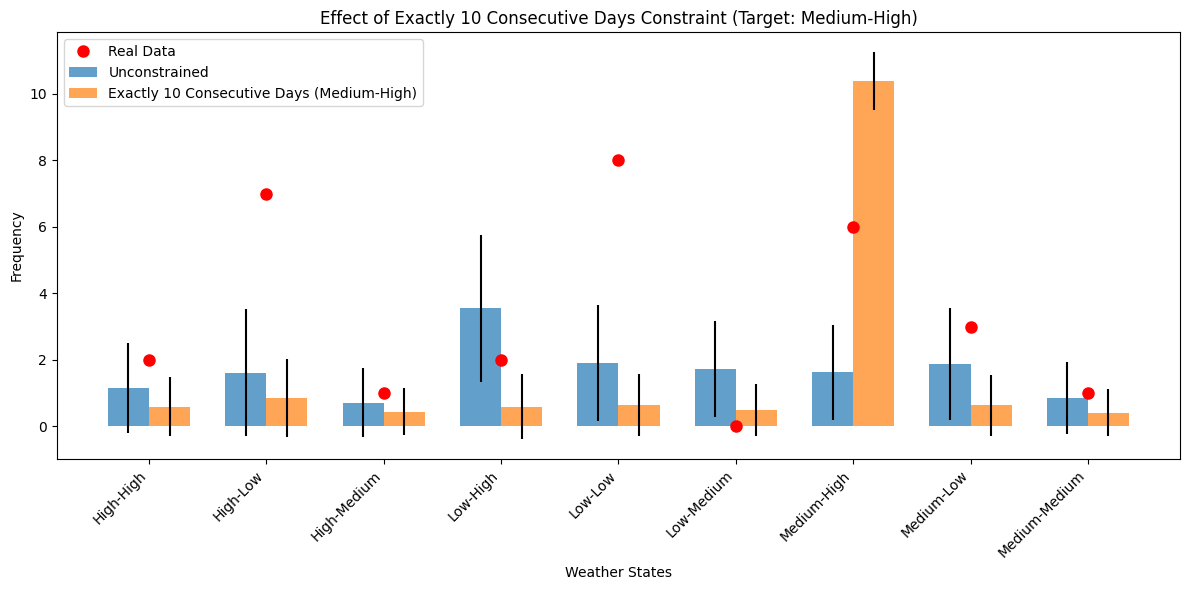

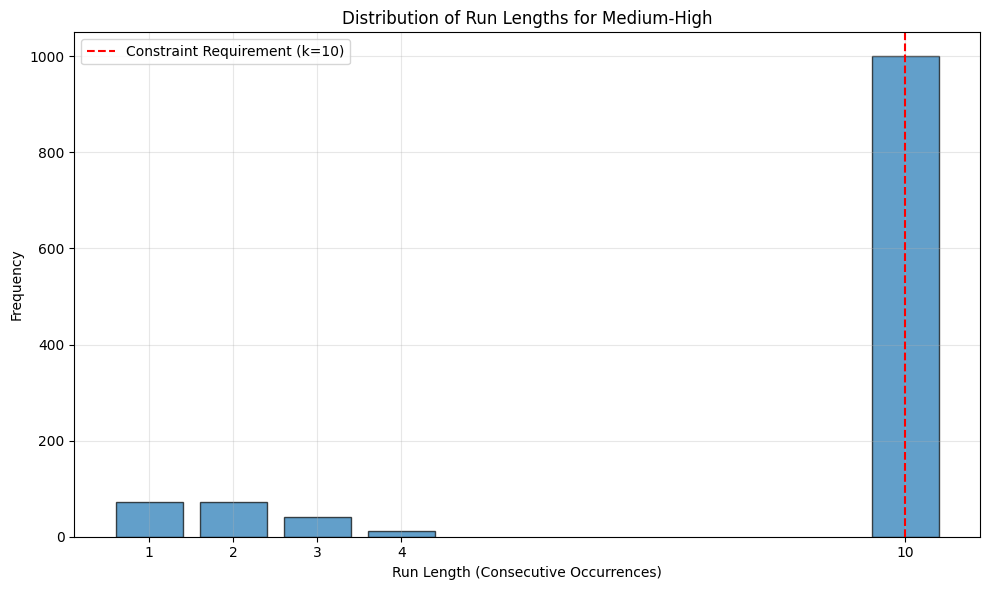

In [24]:
k_day_sim = test_k_exact_consecutive_days_constraint_monte_carlo()

In [25]:
# get 5 random sequences from monte carlo simulation 
constrained_sequences = k_day_sim['constrained_results']['all_sequences']
random_sequences = random.sample(constrained_sequences, 5)

In [26]:
random_sequences

[['Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'High-High',
  'High-High',
  'Medium-Medium',
  'Low-Low',
  'Low-Low'],
 ['Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Low-Low',
  'Low-High',
  'Low-High',
  'Low-High',
  'Low-Low'],
 ['High-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Low-Medium',
  'Medium-Low',
  'High-Low',
  'High-Low'],
 ['Low-Low',
  'Medium-Medium',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-Medium',
  'High-Low',
  'High-Low'],
 ['Medium-Medium',


In [27]:
def seq_heatmap(random_sequences, state_sequence_test ): 
    # Define all possible state labels (make sure it's the full set from your data)
    all_labels = sorted(set([
        "High-High", "High-Medium", "High-Low",
        "Medium-High", "Medium-Medium", "Medium-Low",
        "Low-High", "Low-Medium", "Low-Low"
    ]))

    # Convert all to np.str_ to match your data if needed
    all_labels = list(map(np.str_, all_labels))

    # Convert test sequence counts to a row
    test_counts = Counter(state_sequence_test)
    test_row = [test_counts.get(label, 0) for label in all_labels]

    # Collect counts from generated sequences
    rows = []
    labels = []

    for i, seq in enumerate(random_sequences):
        seq_counts = Counter(seq)
        row = [seq_counts.get(label, 0) for label in all_labels]
        rows.append(row)
        labels.append(f"Generated {i+1}")

    # Add test row
    rows.append(test_row)
    labels.append("Test")

    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=all_labels, index=labels)

    # Plot heatmap
    plt.figure(figsize=(14, 7))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={"label": "Frequency"})
    plt.title("Frequency of Weather States in k-Day Constrained Generated vs Test Sequences", size =18 )
    plt.ylabel("Sequence", size = 14)
    plt.xlabel("State Label", size =14)
    plt.tight_layout()
    plt.show()
    

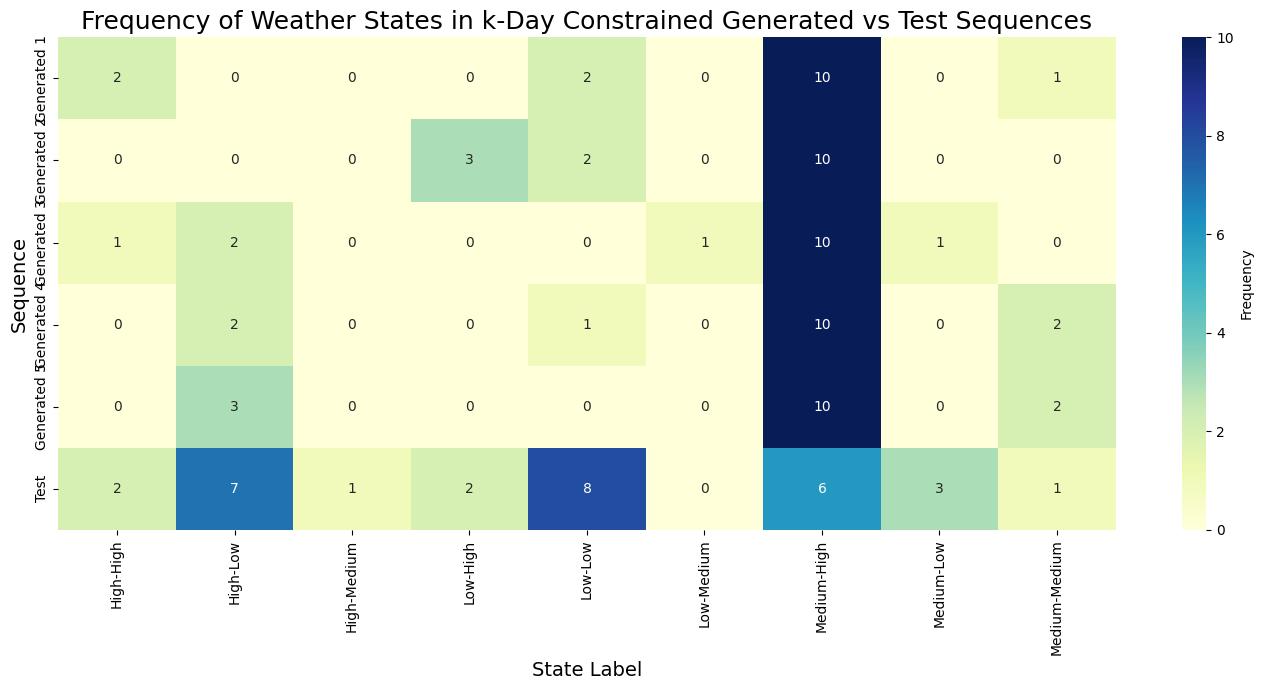

In [28]:
seq_heatmap(random_sequences, state_sequence_test)

In [29]:
random_sequences

[['Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'High-High',
  'High-High',
  'Medium-Medium',
  'Low-Low',
  'Low-Low'],
 ['Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Low-Low',
  'Low-High',
  'Low-High',
  'Low-High',
  'Low-Low'],
 ['High-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Low-Medium',
  'Medium-Low',
  'High-Low',
  'High-Low'],
 ['Low-Low',
  'Medium-Medium',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-High',
  'Medium-Medium',
  'High-Low',
  'High-Low'],
 ['Medium-Medium',


In [30]:
def sequence_line_plot(random_sequences, weather_var):
    plt.figure(figsize=(14, 7))

    # Plot the actual (test) sequence
    days = daily_mean_test_df['day']
    plt.plot(days, daily_mean_test_df[weather_var], marker='o', label=f'Apr 2025 {weather_var.capitalize()}', color='blue', linewidth=2)

    # For each generated sequence
    for idx, gen in enumerate(random_sequences):
        temperature_gen1, precipitation_gen1 = zip(*[str(state).split('-') for state in gen])
        prec_val_gen1 = []
        temp_val_gen1 = []

        for i in temperature_gen1: 
            if i == 'Low': 
                temp_val_gen1.append(float(random.choice(temp_low1)))
            elif i == 'Medium': 
                temp_val_gen1.append(float(random.choice(temp_med1)))
            elif i == 'High': 
                temp_val_gen1.append(float(random.choice(temp_high1)))

        for i in precipitation_gen1: 
            if i == 'Low': 
                prec_val_gen1.append(float(random.choice(prec_low1)))
            elif i == 'Medium': 
                prec_val_gen1.append(float(random.choice(prec_med1)))
            elif i == 'High': 
                prec_val_gen1.append(float(random.choice(prec_high1)))

        df_gen = pd.DataFrame({
            'temp': temp_val_gen1,
            'precip': prec_val_gen1
        })
        df_gen.index = df_gen.index + 1  # match day index

        # Plot the selected variable (temperature or precipitation)
        plt.plot(df_gen.index, df_gen[weather_var], marker='o', label=f'Generated #{idx+1}', alpha=0.6)

    # Dynamic label and title based on variable
    y_label = 'Temperature (°C)' if weather_var == 'temp' else 'Precipitation (mm)'
    title_var = 'Temperature' if weather_var == 'temp' else 'Precipitation'
    plt.xlim(0,15)

    plt.xlabel('Day of April', size=18)
    plt.ylabel(y_label, size=18)
    plt.title(f'Average Daily {title_var}: Synthesized Rainy 2 weeks of April  ', size=26)
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

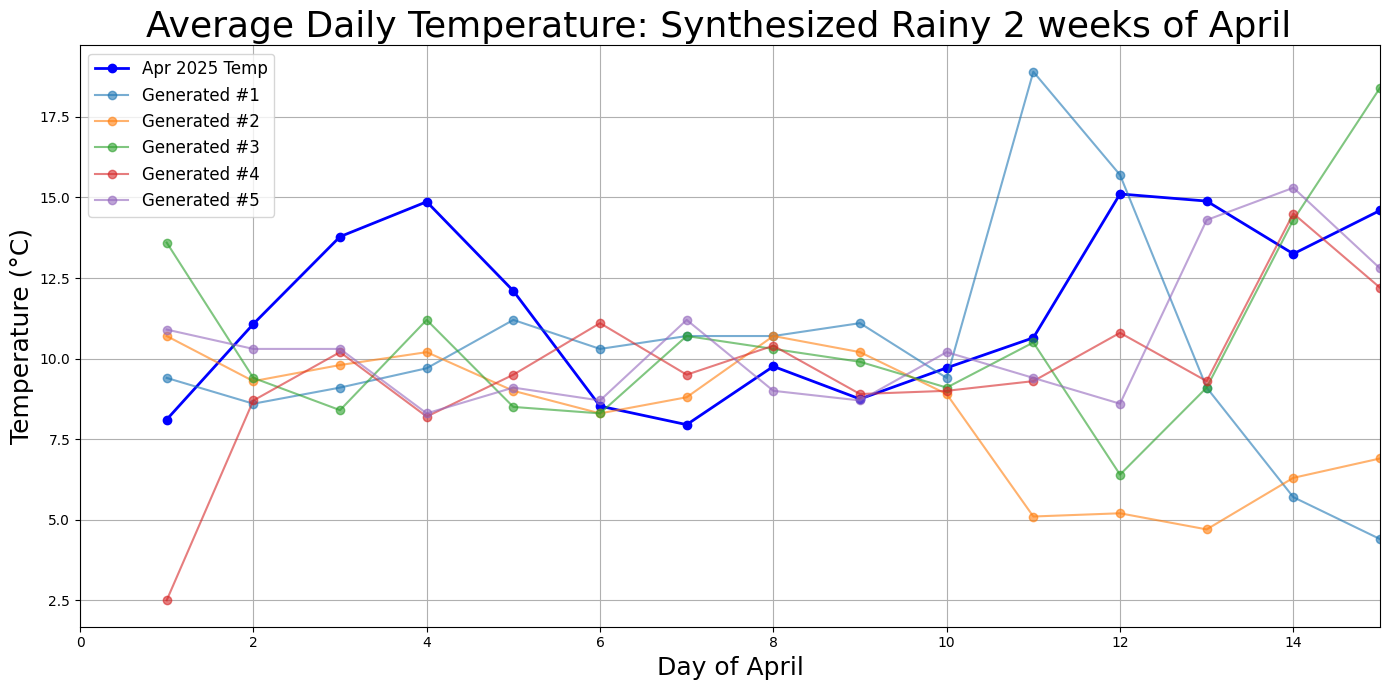

In [31]:
sequence_line_plot(random_sequences, 'temp')

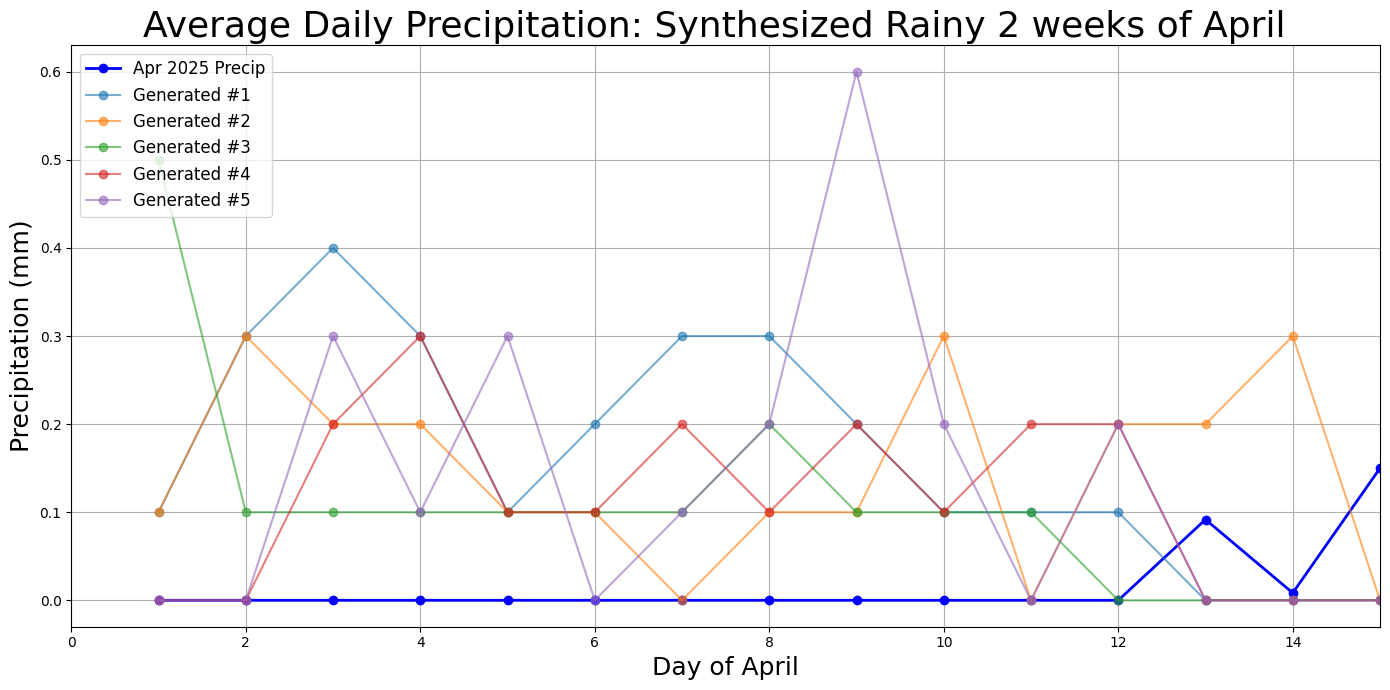

In [32]:
sequence_line_plot(random_sequences, 'precip')

In [57]:
def sequence_line_plot_categorical(random_sequences, state_type='temp'):
    """
    Plot weather sequences showing categorical states (Low, Medium, High) with colored zones
    
    Parameters:
    - random_sequences: list of weather state sequences
    - weather_var: 'temp' or 'precip' 
    - state_type: 'temp' for temperature categories, 'precip' for precipitation categories
    """
    plt.figure(figsize=(14, 7))
    
    # Define categorical mapping
    category_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    category_labels = ['Low', 'Medium', 'High']
    
    # Extract test sequence categories
    test_categories = []
    if state_type == 'temp':
        for _, row in daily_mean_test_df.iterrows():
            if row['temp'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['temp'], 33):
                test_categories.append('Low')
            elif row['temp'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['temp'], 67):
                test_categories.append('Medium')
            else:
                test_categories.append('High')
    else:  # precipitation
        for _, row in daily_mean_test_df.iterrows():
            if row['precip'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['precip'], 33):
                test_categories.append('Low')
            elif row['precip'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['precip'], 67):
                test_categories.append('Medium')
            else:
                test_categories.append('High')
    
    # Convert test categories to numeric for plotting
    test_numeric = [category_mapping[cat] for cat in test_categories]
    
    # Add colored background zones
    plt.axhspan(-0.25, 0.5, alpha=0.2, color='lightgreen', label='Low')
    plt.axhspan(0.5, 1.5, alpha=0.2, color='yellow', label='Medium')
    plt.axhspan(1.5, 2.25, alpha=0.2, color='lightcoral', label='High')
    
    # Plot the test sequence
    # days = df['day']
    # plt.plot(days, test_numeric, marker='o', label='Test', color='blue', linewidth=2, markersize=4, alpha=0.7)
    
    markers = ['s', 'd', '<', 'X', 'P']
    linestyles = ['--' ]


    # Process and plot generated sequences
    for idx, gen in enumerate(random_sequences):
        if state_type == 'temp':
            categories = [state.split('-')[0] for state in gen]  # Extract temperature part
        else:
            categories = [state.split('-')[1] for state in gen]  # Extract precipitation part
        
        # Convert to numeric for plotting
        numeric_values = [category_mapping[cat] for cat in categories]
        
        # Create day indices (1-31 for January)
        day_indices = list(range(1, len(numeric_values) + 1))
        
        # Use different marker for each sequence
        marker = markers[idx % len(markers)]  # Cycle through markers if more sequences than markers
        linestyle = linestyles[idx % len(linestyles)]

        plt.plot(day_indices, numeric_values, marker=marker, linestyle = linestyle,
                label=f'Generated #{idx+1}', alpha=0.5, linewidth=2.5, markersize=8)
    
    
    # Customize the plot
    # plt.yticks([0, 1, 2], ['Low', 'Medium', 'High'])
    plt.ylim(-0.3, 2.3)
    
    # Add threshold lines
    plt.axhline(y=0.5, color='darkgreen', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axhline(y=1.5, color='darkred', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Labels and title
    var_name = 'Temperature' if state_type == 'temp' else 'Precipitation'
    plt.xlabel('Day of April', size=18)
    plt.ylabel(f'{var_name} Category', size=18)
    plt.title(f'Daily {var_name} Categories: 10-day Rainy Spring in April (2 weeks) Scenario', size=24)
    plt.grid(True, alpha=0.3)
    
    # Legend
    # plt.legend(loc='upper left', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{var_name} Category Distribution:")
    test_counts = {cat: test_categories.count(cat) for cat in category_labels}
    print("Test sequence:", test_counts)
    
    for idx, gen in enumerate(random_sequences):
        if state_type == 'temp':
            gen_categories = [state.split('-')[0] for state in gen]
        else:
            gen_categories = [state.split('-')[1] for state in gen]
        gen_counts = {cat: gen_categories.count(cat) for cat in category_labels}
        print(f"Generated #{idx+1}:", gen_counts)

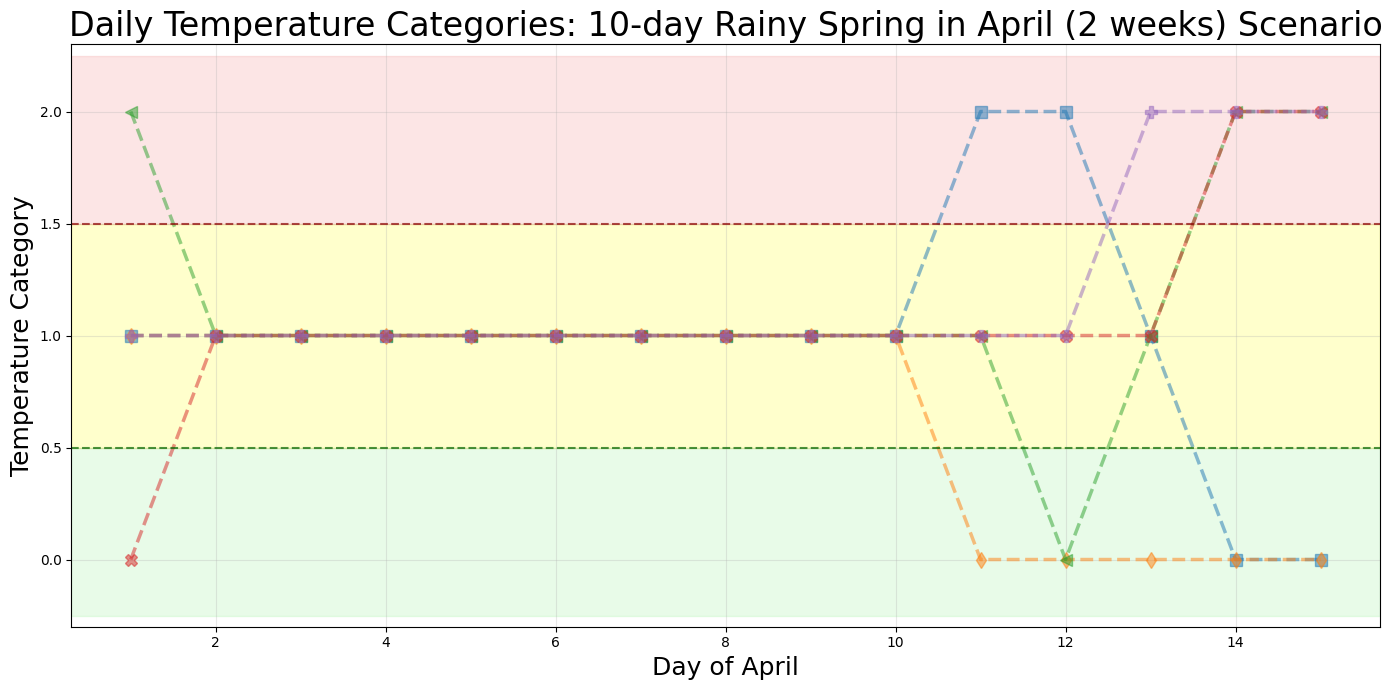


Temperature Category Distribution:
Test sequence: {'Low': 0, 'Medium': 0, 'High': 30}
Generated #1: {'Low': 2, 'Medium': 11, 'High': 2}
Generated #2: {'Low': 5, 'Medium': 10, 'High': 0}
Generated #3: {'Low': 1, 'Medium': 11, 'High': 3}
Generated #4: {'Low': 1, 'Medium': 12, 'High': 2}
Generated #5: {'Low': 0, 'Medium': 12, 'High': 3}


In [58]:
sequence_line_plot_categorical(random_sequences, 'temp')

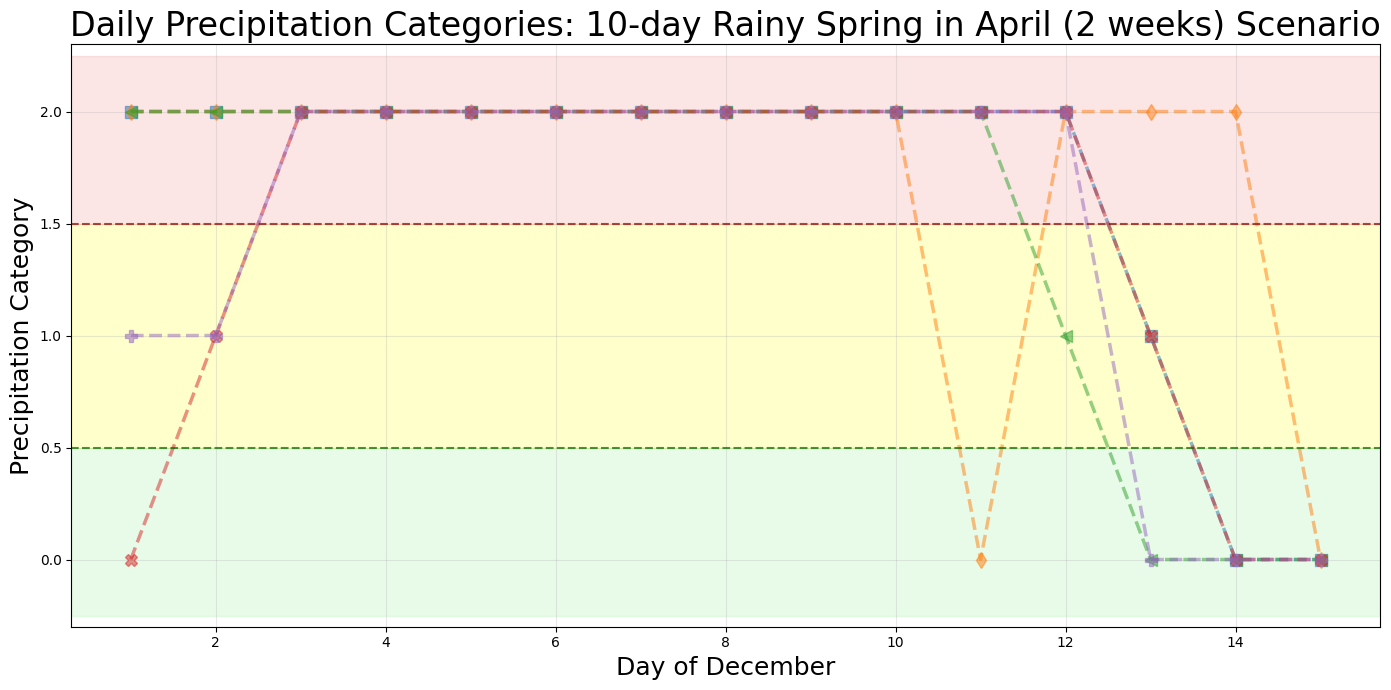


Precipitation Category Distribution:
Test sequence: {'Low': 18, 'Medium': 5, 'High': 7}
Generated #1: {'Low': 2, 'Medium': 1, 'High': 12}
Generated #2: {'Low': 2, 'Medium': 0, 'High': 13}
Generated #3: {'Low': 3, 'Medium': 1, 'High': 11}
Generated #4: {'Low': 3, 'Medium': 2, 'High': 10}
Generated #5: {'Low': 3, 'Medium': 2, 'High': 10}


In [45]:
sequence_line_plot_categorical(random_sequences, 'precip')

In [60]:
def sequence_line_plot_cat(random_sequences, weather_var):
    plt.figure(figsize=(14, 7))

    # Collect all values from all sequences to calculate thresholds
    all_values = []
    
    # Add test sequence values
    all_values.extend(daily_mean_test_df[weather_var].tolist())
    
    # For each generated sequence, collect values
    generated_sequences_data = []
    for idx, gen in enumerate(random_sequences):
        temperature_gen1, precipitation_gen1 = zip(*[str(state).split('-') for state in gen])
        prec_val_gen1 = []
        temp_val_gen1 = []

        for i in temperature_gen1: 
            if i == 'Low': 
                temp_val_gen1.append(float(random.choice(temp_low1)))
            elif i == 'Medium': 
                temp_val_gen1.append(float(random.choice(temp_med1)))
            elif i == 'High': 
                temp_val_gen1.append(float(random.choice(temp_high1)))

        for i in precipitation_gen1: 
            if i == 'Low': 
                prec_val_gen1.append(float(random.choice(prec_low1)))
            elif i == 'Medium': 
                prec_val_gen1.append(float(random.choice(prec_med1)))
            elif i == 'High': 
                prec_val_gen1.append(float(random.choice(prec_high1)))

        df_gen = pd.DataFrame({
            'temp': temp_val_gen1,
            'precip': prec_val_gen1
        })
        df_gen.index = df_gen.index + 1  # match day index
        
        # Store the generated data
        generated_sequences_data.append(df_gen)
        
        # Add values to all_values for threshold calculation
        all_values.extend(df_gen[weather_var].tolist())

    # Calculate thresholds based on all values (test + generated)
    all_values = np.array(all_values)
    low_threshold = np.percentile(all_values, 33.33)
    high_threshold = np.percentile(all_values, 66.67)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    
    # Add colored background zones - only show the actual data range
    y_margin = (max_val - min_val) * 0.05  # 5% margin for better visualization
    plot_min = min_val - y_margin
    plot_max = max_val + y_margin
    
    plt.axhspan(plot_min, low_threshold, alpha=0.2, color='lightgreen', label='Low')
    plt.axhspan(low_threshold, high_threshold, alpha=0.2, color='yellow', label='Medium ')
    plt.axhspan(high_threshold, plot_max, alpha=0.2, color='lightcoral', label='High ')

    # Plot the actual (test) sequence
    days = daily_mean_test_df['day']
    plt.plot(days, daily_mean_test_df[weather_var], marker='o', 
             label=f'Test {weather_var.capitalize()}', color='blue', linewidth=2, markersize=2, alpha=0.7)
    
    markers = ['s', 'd', '<', 'X', 'P']
    # Plot each generated sequence
    for idx, df_gen in enumerate(generated_sequences_data):
        marker = markers[idx % len(markers)]  # Cycle through markers if more sequences than markers
        plt.plot(df_gen.index, df_gen[weather_var], marker=marker, 
                label=f'Generated #{idx+1}', linestyle='--', alpha=0.5, linewidth=2.5, markersize=8)

    # Dynamic label and title based on variable
    y_label = 'Temperature (°C)' if weather_var == 'temp' else 'Precipitation (mm)'
    title_var = 'Temperature' if weather_var == 'temp' else 'Precipitation'

    plt.xlabel('Day of April', size=18)
    plt.ylabel(y_label, size=18)
    plt.title(f'Average Daily {title_var}: 10-day Rainy Spring in April (2 weeks) Scenario', size=24)
    plt.grid(True, alpha=0.3)
    plt.xlim(0,16)
    
    # Create legend with categories and sequences
    plt.legend(loc='upper left', fontsize=12)
    
    # Add threshold lines for clarity
    plt.axhline(y=low_threshold, color='darkgreen', linestyle='--', alpha=0.7, linewidth=1)
    plt.axhline(y=high_threshold, color='darkred', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Print threshold information
    print(f"\n{title_var} Categorization Thresholds:")
    print(f"Low: ≤{low_threshold:.2f} (bottom 33.33% of data)")
    print(f"Medium: {low_threshold:.2f} to {high_threshold:.2f} (middle 33.33% of data)")
    print(f"High: ≥{high_threshold:.2f} (top 33.33% of data)")
    if weather_var == 'temp':
        print(f"Plot range: {plot_min:.2f} (min from temp_low1) to {plot_max:.2f} (max from temp_high1)")
    else:
        print(f"Plot range: {plot_min:.2f} (min from prec_low1) to {plot_max:.2f} (max from prec_high1)")

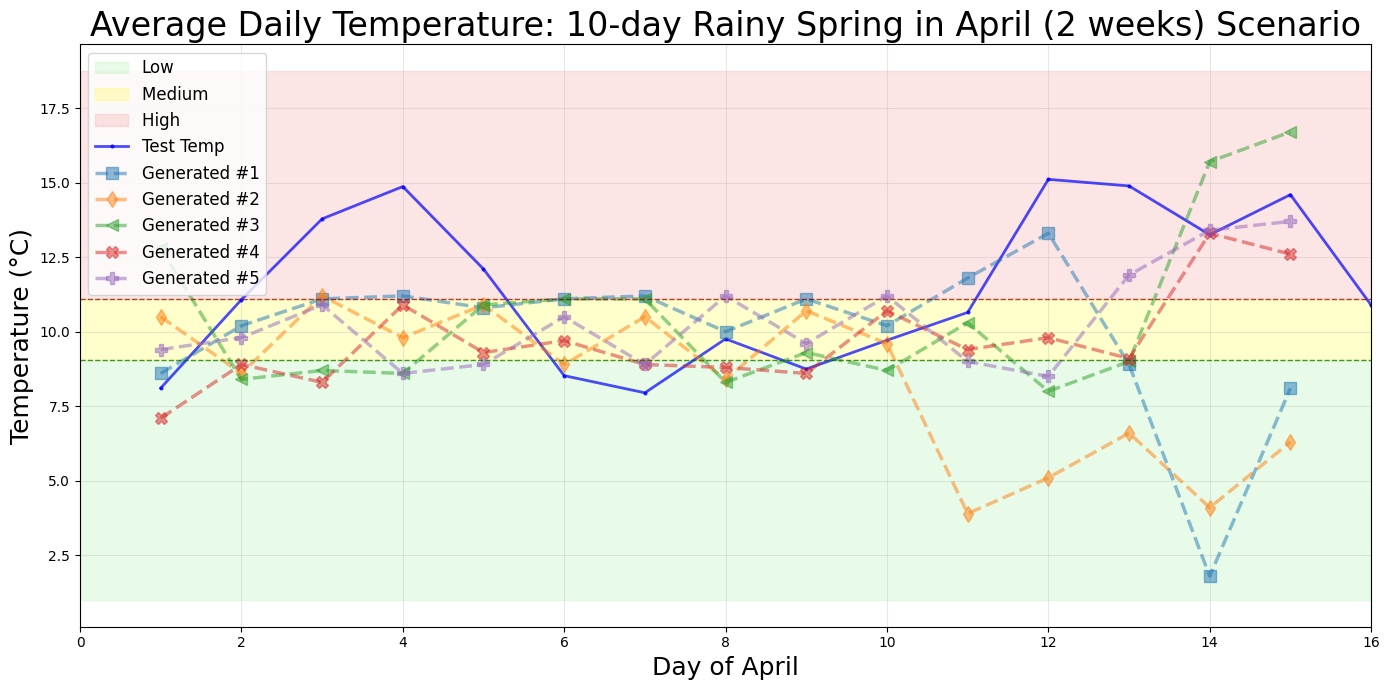


Temperature Categorization Thresholds:
Low: ≤9.07 (bottom 33.33% of data)
Medium: 9.07 to 11.10 (middle 33.33% of data)
High: ≥11.10 (top 33.33% of data)
Plot range: 0.99 (min from temp_low1) to 18.75 (max from temp_high1)


In [61]:
sequence_line_plot_cat(random_sequences, 'temp')

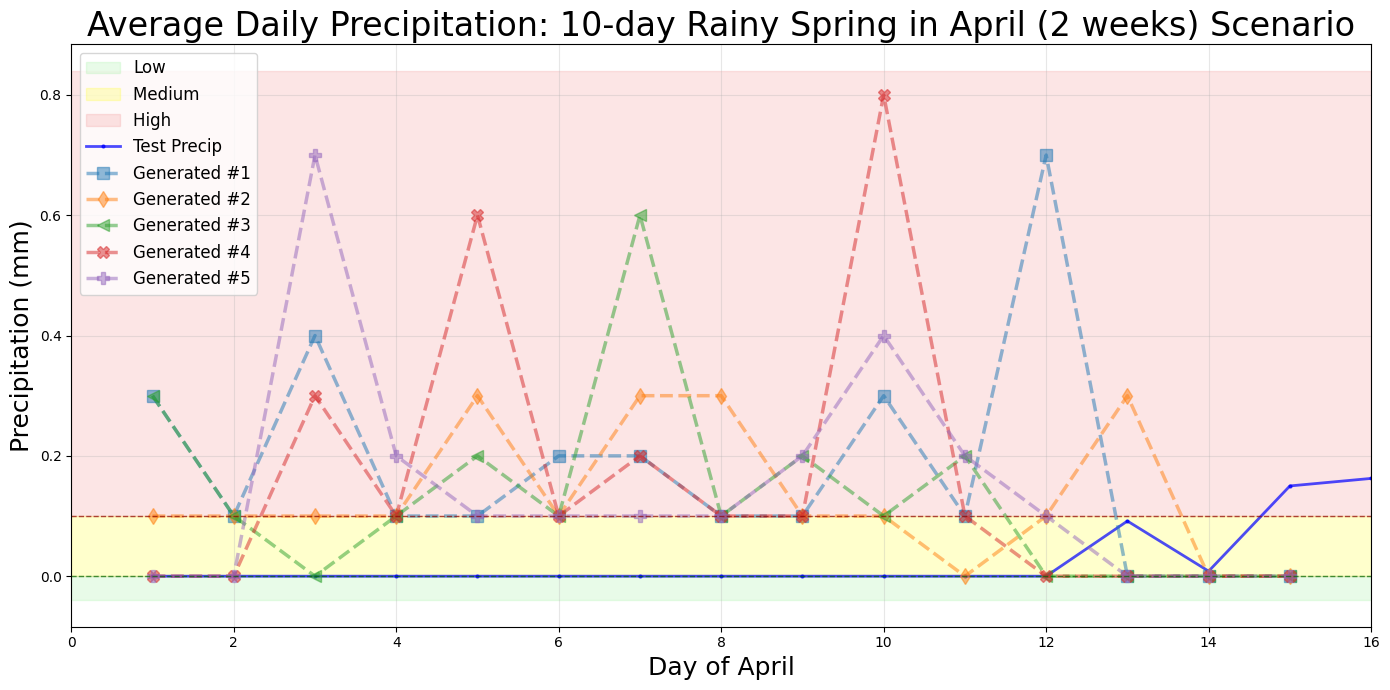


Precipitation Categorization Thresholds:
Low: ≤0.00 (bottom 33.33% of data)
Medium: 0.00 to 0.10 (middle 33.33% of data)
High: ≥0.10 (top 33.33% of data)
Plot range: -0.04 (min from prec_low1) to 0.84 (max from prec_high1)


In [62]:
sequence_line_plot_cat(random_sequences, 'precip')

Text(0.5, 0, 'Instances')

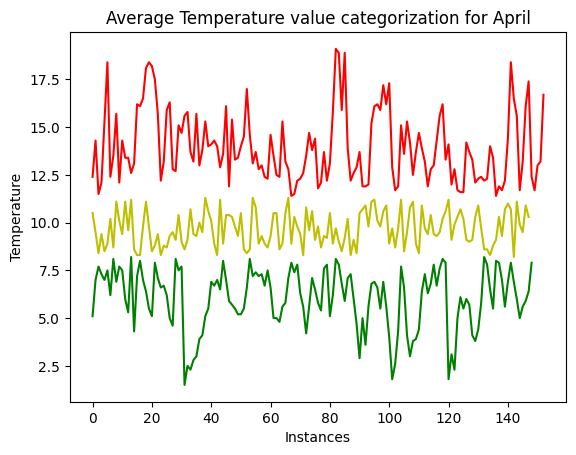

In [63]:
plt.plot(temp_low1, color = 'g')
plt.plot(temp_med1, color='y')
plt.plot(temp_high1, color='r')
plt.title('Average Temperature value categorization for April')
plt.ylabel('Temperature')
plt.xlabel('Instances')